In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline

from torchvision.datasets import ImageFolder
from torch.utils import data
import cv2

device = 'cuda'
img_path = '/data2/wanghao/sunguangyan/GTSRB/Train/0/00000_00000_00000.png'

/data2/wanghao/softs/anaconda3/envs/opendet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Feature Map for Resnet

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

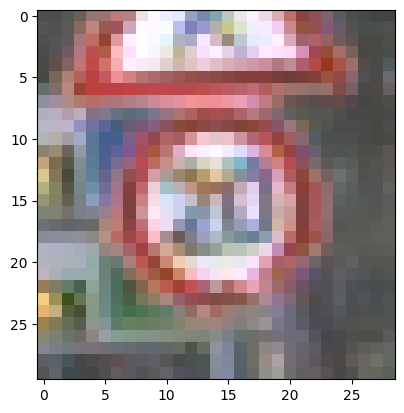

In [3]:
image = Image.open(str(img_path))
plt.imshow(image)

In [4]:
model = models.resnet18(pretrained='/data2/wanghao/sunguangyan/TrafficSignRecongnition/Bonus/checkpoints/resnet18_epoch10_lr1e-05_wd0.001.pt')
model.cuda()

/data2/wanghao/softs/anaconda3/envs/opendet/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data2/wanghao/softs/anaconda3/envs/opendet/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


In [6]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [7]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
# for feature_map in outputs:
#     print(feature_map.shape)

17


In [8]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
# for fm in processed:
#     print(fm.shape)

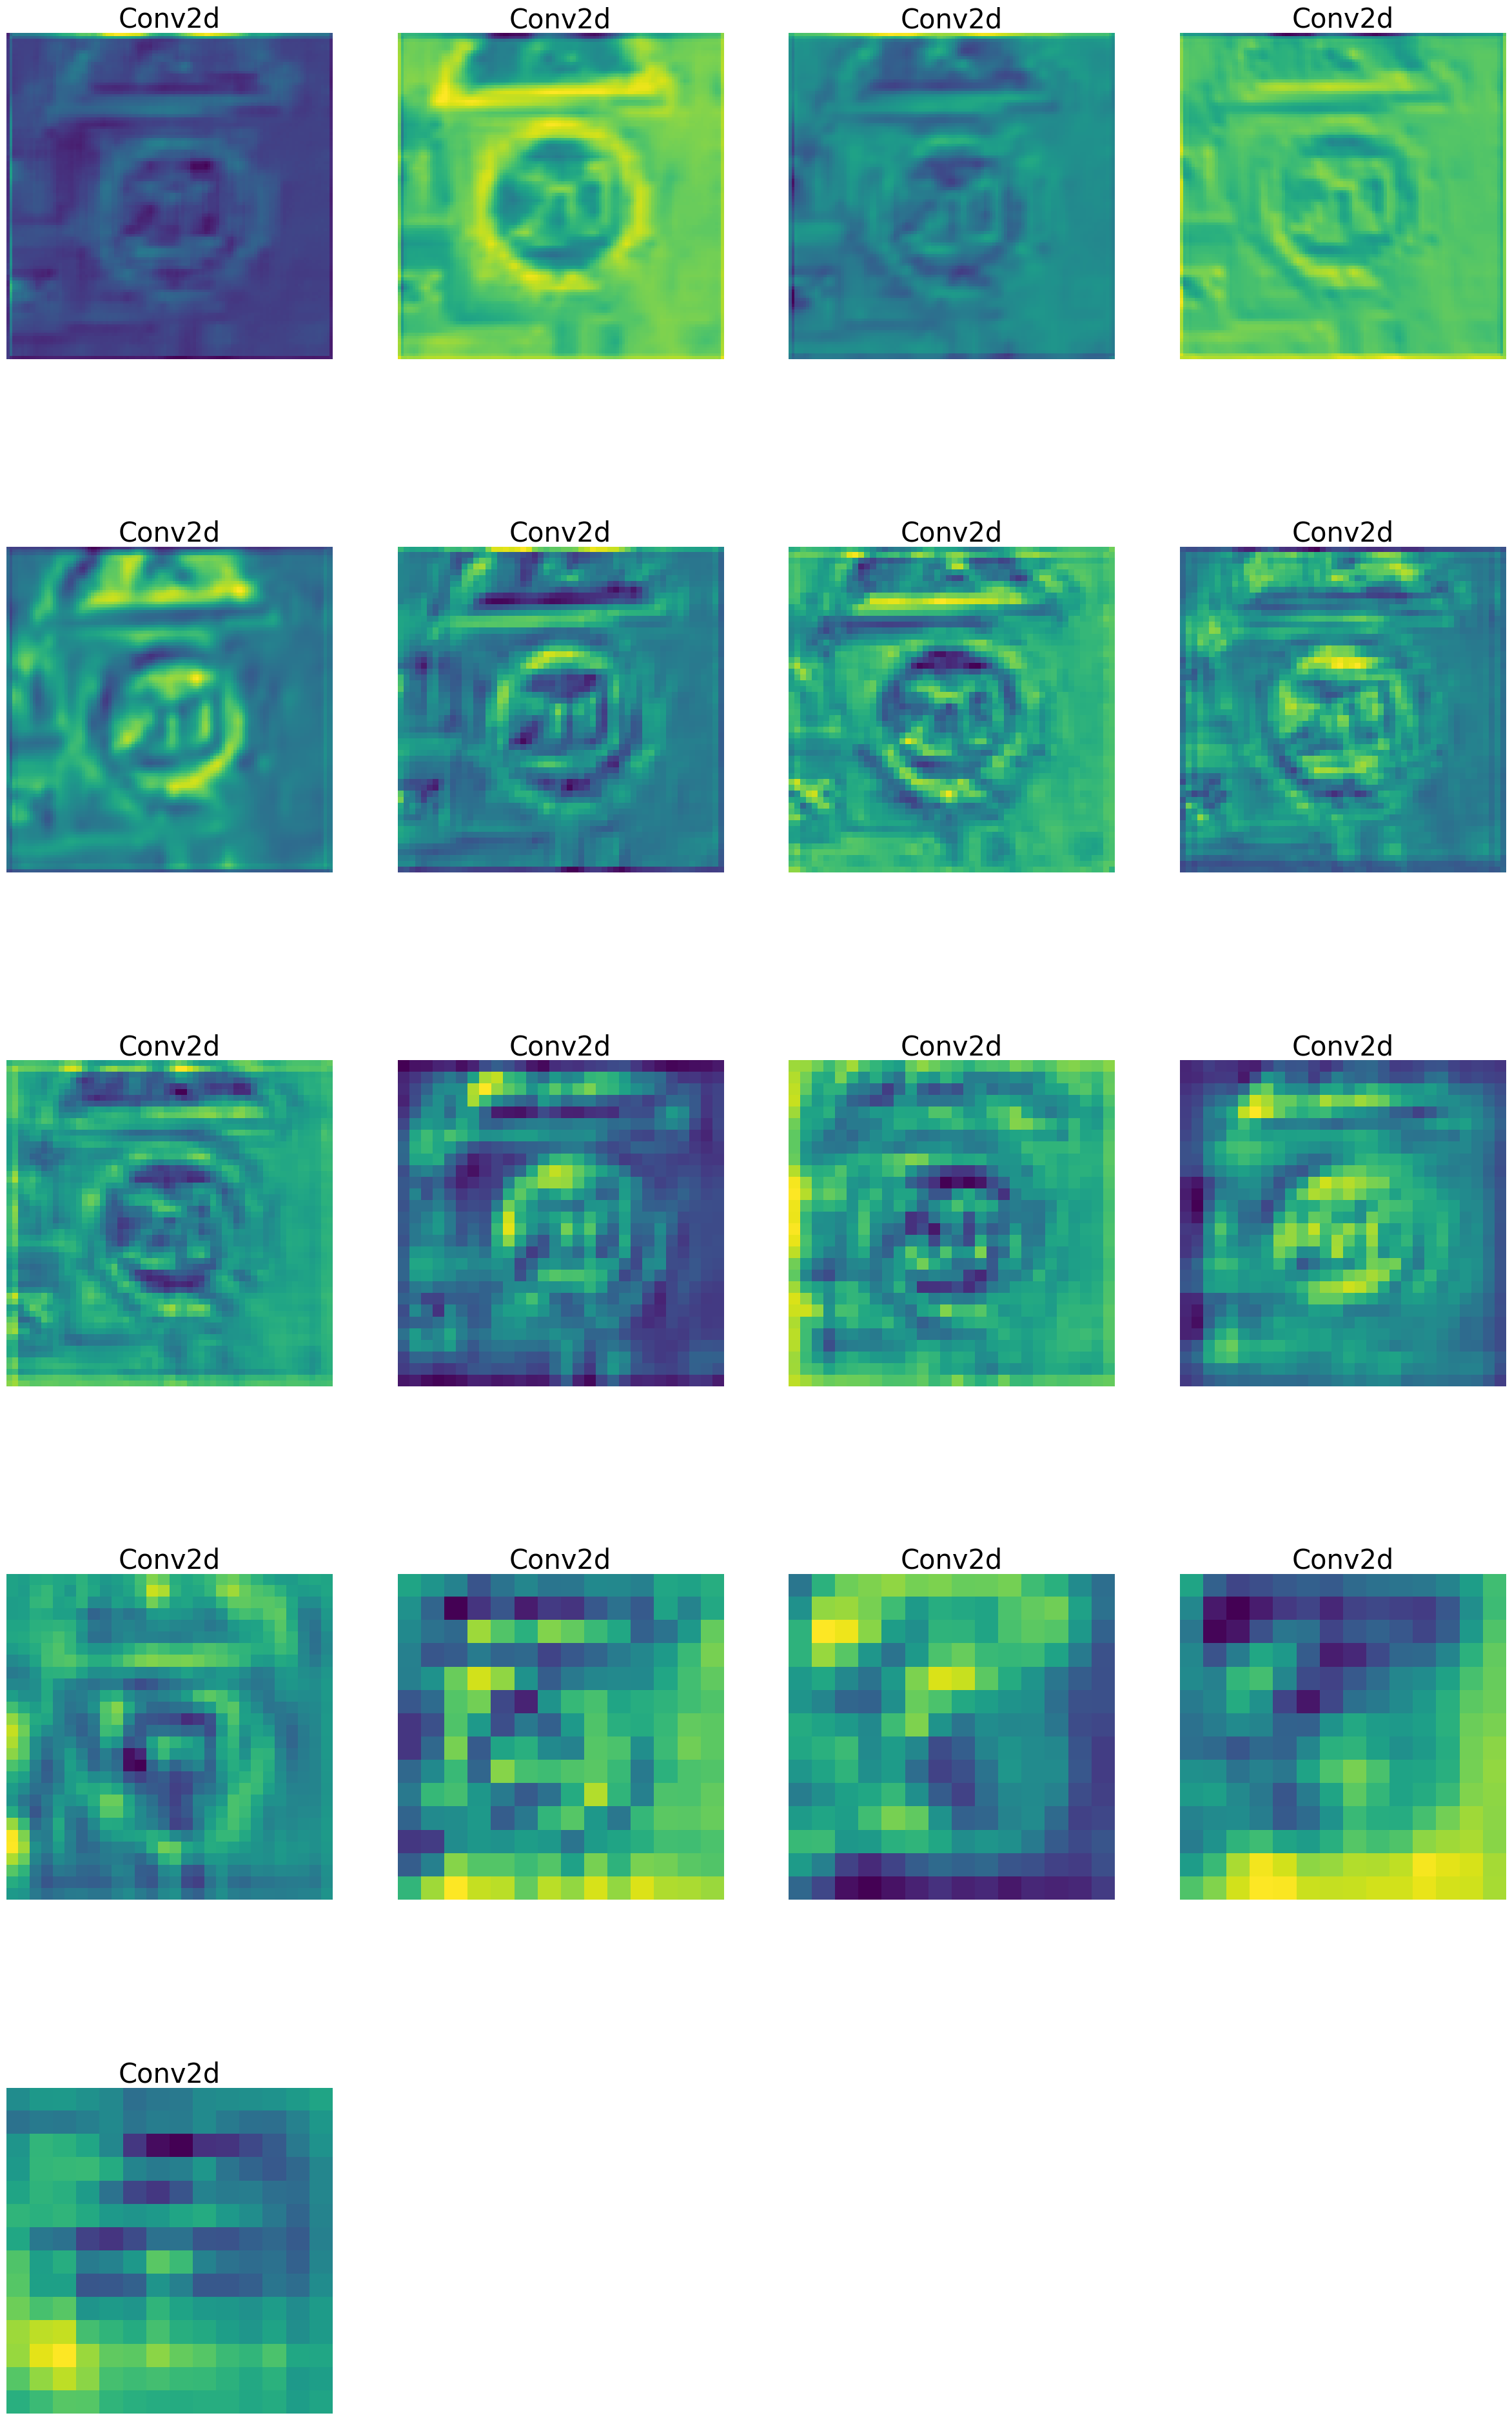

In [9]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

# Grad-CAM

In [10]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

backward_hook = model.layer4[-1].register_full_backward_hook(backward_hook)
forward_hook = model.layer4[-1].register_forward_hook(forward_hook)


Image shape after: torch.Size([3, 224, 224])
Forward hook running...
Activations size: torch.Size([1, 512, 7, 7])
Backward hook running...
Gradients size: torch.Size([1, 512, 7, 7])


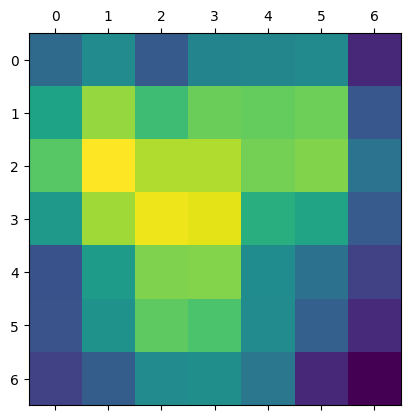

In [11]:
image = Image.open(str(img_path))
image = transform(image)
print(f"Image shape after: {image.shape}")
image = image.to(device)

# since we're feeding only one image, it is a 3d tensor (3, 256, 256). 
# we need to unsqueeze to it has 4 dimensions (1, 3, 256, 256) as 
# the model expects it to.
model(image.unsqueeze(0)).mean().backward()
# here we did the forward and the backward pass in one line.

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

import torch.nn.functional as F

# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.detach().cpu())

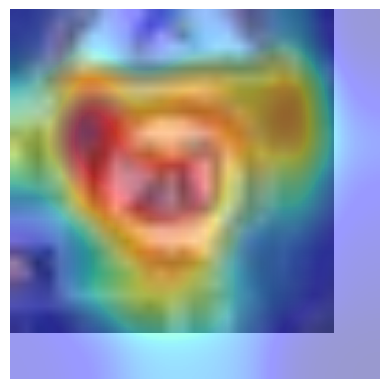

In [12]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import PIL

# Create a figure and plot the first image
fig, ax = plt.subplots()
ax.axis('off') # removes the axis markers

# First plot the original image
ax.imshow(to_pil_image(image, mode='RGB'))

# Resize the heatmap to the same size as the input image and defines
# a resample algorithm for increasing image resolution
# we need heatmap.detach() because it can't be converted to numpy array while
# requiring gradients
overlay = to_pil_image(heatmap.detach(), mode='F').resize((256,256), resample=PIL.Image.BICUBIC)

# Apply any colormap you want
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

# Plot the heatmap on the same axes, 
# but with alpha < 1 (this defines the transparency of the heatmap)
ax.imshow(overlay, alpha=0.4, interpolation='nearest')

# Show the plot
plt.show()

In [13]:
backward_hook.remove()
forward_hook.remove()

# VIT Attention Map

In [14]:
from visualizer import get_local
get_local.activate()

In [15]:
import torch
import torchvision.transforms as T
from timm.models.vision_transformer import vit_small_patch16_224
import json
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def grid_show(to_shows, cols):
    rows = (len(to_shows)-1) // cols + 1
    it = iter(to_shows)
    fig, axs = plt.subplots(rows, cols, figsize=(rows*8.5, cols*2))
    for i in range(rows):
        for j in range(cols):
            try:
                image, title = next(it)
            except StopIteration:
                image = np.zeros_like(to_shows[0][0])
                title = 'pad'
            axs[i, j].imshow(image)
            axs[i, j].set_title(title)
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
    plt.show()

def visualize_head(att_map):
    ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(att_map)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()
    
def visualize_heads(att_map, cols):
    to_shows = []
    att_map = att_map.squeeze()
    for i in range(att_map.shape[0]):
        to_shows.append((att_map[i], f'Head {i}'))
    average_att_map = att_map.mean(axis=0)
    to_shows.append((average_att_map, 'Head Average'))
    grid_show(to_shows, cols=cols)

def gray2rgb(image):
    return np.repeat(image[...,np.newaxis],3,2)
    
def cls_padding(image, mask, cls_weight, grid_size):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
        
    image = np.array(image)

    H, W = image.shape[:2]
    delta_H = int(H/grid_size[0])
    delta_W = int(W/grid_size[1])
    
    padding_w = delta_W
    padding_h = H
    padding = np.ones_like(image) * 255
    padding = padding[:padding_h, :padding_w]
    
    padded_image = np.hstack((padding,image))
    padded_image = Image.fromarray(padded_image)
    draw = ImageDraw.Draw(padded_image)
    draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0)) # PIL.Image.size = (W,H) not (H,W)

    mask = mask / max(np.max(mask),cls_weight)
    cls_weight = cls_weight / max(np.max(mask),cls_weight)
    
    if len(padding.shape) == 3:
        padding = padding[:,:,0]
        padding[:,:] = np.min(mask)
    mask_to_pad = np.ones((1,1)) * cls_weight
    mask_to_pad = Image.fromarray(mask_to_pad)
    mask_to_pad = mask_to_pad.resize((delta_W, delta_H))
    mask_to_pad = np.array(mask_to_pad)

    padding[:delta_H,  :delta_W] = mask_to_pad
    padded_mask = np.hstack((padding, mask))
    padded_mask = padded_mask
    
    meta_mask = np.zeros((padded_mask.shape[0], padded_mask.shape[1],4))
    meta_mask[delta_H:,0: delta_W, :] = 1 
    
    return padded_image, padded_mask, meta_mask
    

def visualize_grid_to_grid_with_cls(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    attention_map = att_map[grid_index]
    cls_weight = attention_map[0]
    
    mask = attention_map[1:].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    padded_image ,padded_mask, meta_mask = cls_padding(image, mask, cls_weight, grid_size)
    
    if grid_index != 0: # adjust grid_index since we pad our image
        grid_index = grid_index + (grid_index-1) // grid_size[1]
        
    grid_image = highlight_grid(padded_image, [grid_index], (grid_size[0], grid_size[1]+1))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(padded_mask, alpha=alpha, cmap='rainbow')
    ax[1].imshow(meta_mask)
    ax[1].axis('off')
    

def visualize_grid_to_grid(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    H,W = att_map.shape
    with_cls_token = False
      
    grid_image = highlight_grid(image, [grid_index], grid_size)
    
    mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')
    ax[1].axis('off')
    plt.show()
    
def highlight_grid(image, grid_indexes, grid_size=14):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    image = image.copy()
    for grid_index in grid_indexes:
        x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
        a= ImageDraw.ImageDraw(image)
        a.rectangle([(y*w,x*h),(y*w+w,x*h+h)],fill =None,outline ='red',width =2)
    return image

In [17]:
image = Image.open(str(img_path))

normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transforms = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            normalize,
        ])
input_tensor = transforms(image).unsqueeze(0)
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [18]:
get_local.clear()
with torch.no_grad():
    vit = vit_small_patch16_224(pretrained=True)
    out = vit(input_tensor)

In [19]:
cache = get_local.cache
print(list(cache.keys()))

['Attention.forward']


In [20]:
attention_maps = cache['Attention.forward']

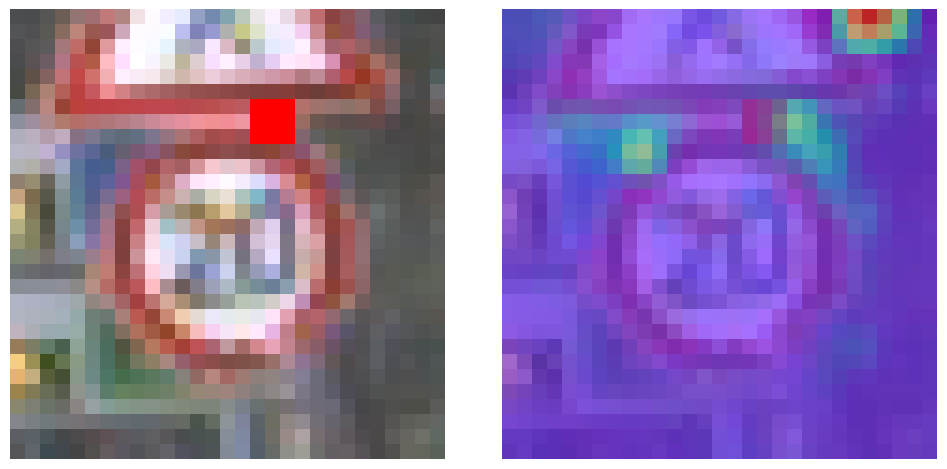

In [32]:
visualize_grid_to_grid(attention_maps[3][0,0,2:,1:], 50 ,image)

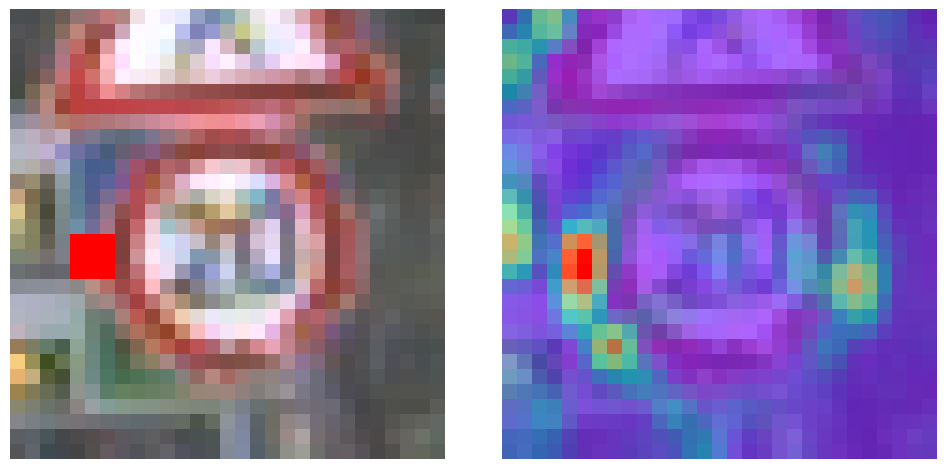

In [31]:
visualize_grid_to_grid(attention_maps[3][0,0,1:,1:], 100 ,image)

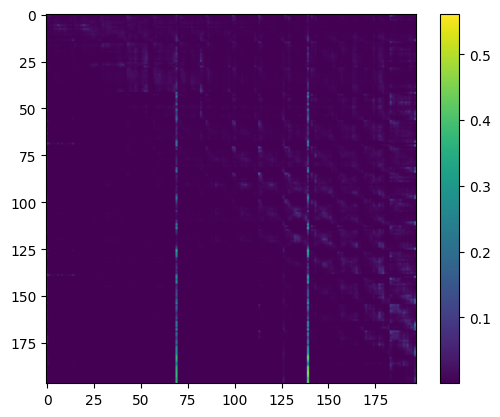

In [24]:
# Attention map of a single head
visualize_head(attention_maps[7][0,1])

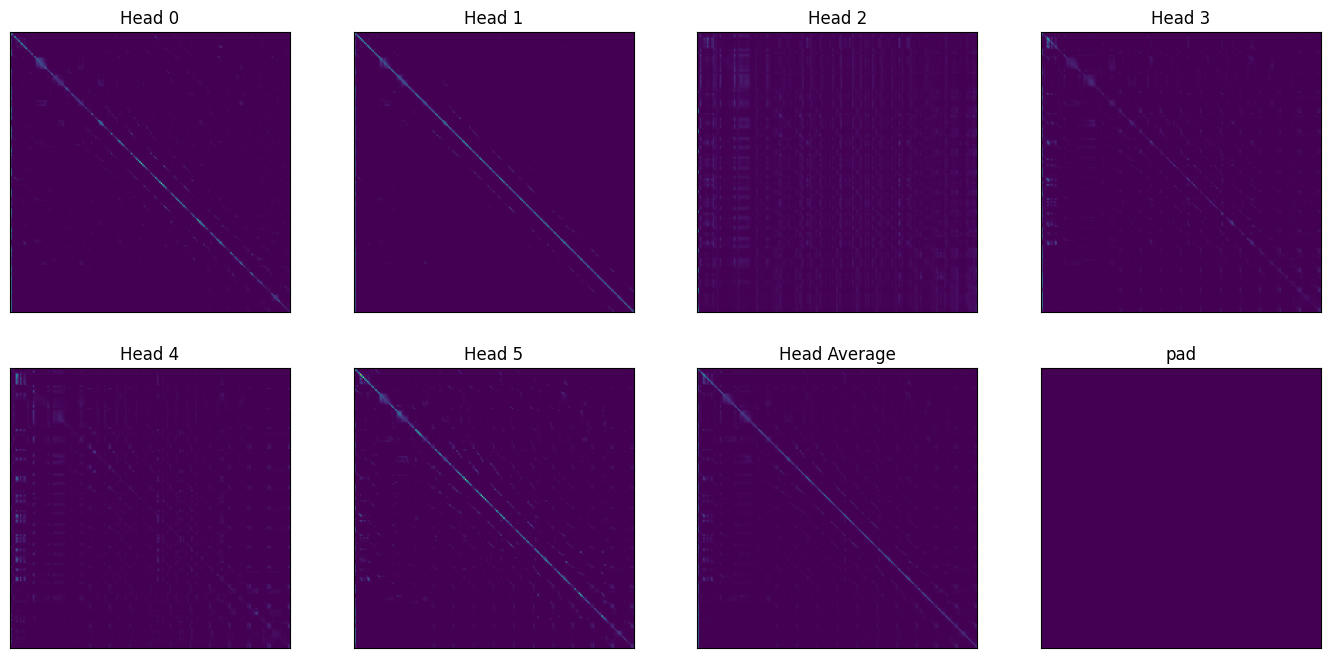

In [25]:
# Attention maps in layer 1
visualize_heads(attention_maps[0], cols=4)
